In [1]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import pandas as pd
import re
import numpy as np 
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from deap import algorithms, base, creator, tools
from nltk import word_tokenize
import re, string
import random
import statistics 
from statistics import mean
import matplotlib.pyplot as plt
import numpy

[nltk_data] Downloading package punkt to /home/spetz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dict_freq = {}  # frequency map for words in list
dict_paired_freq = {}

path = '/home/spetz/Downloads/DeliciousMIL/Data/train-data.dat'
clean_files = []
df = pd.DataFrame()

file = open(path).readlines()
len(file)

#clear data
clear_file=[]
for i in range(len(file)):
    x=re.sub('<.*?>','',file[i])
    clear_file.append(x)

clear_file=clear_file[:]

#perasma tou clear keimenou sto words string
words = ''
for line in clear_file:
    words += line


tokenized_words = word_tokenize(words) # list of all words in new dictionary
WORD_LIST = list(set(tokenized_words)) # create a set out of words so there are no repeats in word list and make list again
dictionary_size = len(WORD_LIST) #6853


#Dhmiourgia dictionary lekseis kai suxnotitas emfanisi tis lekseis se olo to keimeno
for word in tokenized_words: #gia kathe word sto lista leksewn olou tou keimenou
    if word not in dict_freq: 
        dict_freq[word] = 1
    else:
        dict_freq[word] += 1

In [3]:
#TF = (Frequency of the word in the sentence) / (Total number of words in the sentence)
def computeTF(wordDict,bow):
    tfDict={}
    bowCount=len(bow)
    for word,count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

tf=computeTF(dict_freq,tokenized_words)

#IDF: log((Total number of sentences (documents))/(Number of sentences (documents) containing the word))
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(dict_freq,0)
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / (float(val) + 1))
        
    return idfDict

idf=computeIDF(dict_freq)
len(idf)

8520

In [4]:
#FINAL TF-IDF
def computeDFIDF(tfbow,idfs):
    tfidf={}
    for word,val in tfbow.items():
        tfidf[word] = val*idfs[word]

    return tfidf

In [47]:
#final TF-IDF
Tf_idf=computeDFIDF(tf,idf)
#Apothikeusi mono ton timwn
new_list = list(Tf_idf.values())
len(new_list)
tf_idf_Xtrain = np.asarray(new_list)


In [6]:
#Create a FitnessMax class 
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#Create an Individual class 
creator.create("Individual", list, fitness=creator.FitnessMax)

def getFitness(individual):
    counter = 0
    fitness = 0

    #gia kathe thesi sto indi
    for word_index in individual:
        #vale sto string thn antistoixi leksi
        if new_list[word_index] <= 1:
            fitness += new_list[word_index]
        
        else:
            fitness -=20
    
    return fitness,

        
#The toolbox is a container for functions with their arguments
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(new_list))
toolbox.register("population", tools.initRepeat, list, toolbox.individual) 
# Register the genetic operators	
toolbox.register("evaluate", getFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

1 ITERATION 
-- Generation 1 --
 Max fitness:15.565071423421152 && Average fitness:15.537623846158084
-- Generation 2 --
 Max fitness:15.593275700809265 && Average fitness:15.55200114853398
-- Generation 3 --
 Max fitness:15.593275700809265 && Average fitness:15.559327381562841
-- Generation 4 --
 Max fitness:15.5912119731955 && Average fitness:15.570161951535107
-- Generation 5 --
 Max fitness:15.624231615015738 && Average fitness:15.57907037573452
-- Generation 6 --
 Max fitness:15.681328078996565 && Average fitness:15.603181593355336
-- Generation 7 --
 Max fitness:15.681328078996565 && Average fitness:15.617008568367561
-- Generation 8 --
 Max fitness:15.684079715814915 && Average fitness:15.626398529010194
-- Generation 9 --
 Max fitness:15.684079715814915 && Average fitness:15.633415202896993
-- Generation 10 --
 Max fitness:15.684079715814915 && Average fitness:15.650475351170783
-- Generation 11 --
 Max fitness:15.684079715814915 && Average fitness:15.667535499444572
-- Generat

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 Max fitness:15.728793814113164 && Average fitness:15.711080152095022
-- Generation 26 --
<-------------------ITERATION 10 COMPLETED ----------------->
 Max fitness:15.733609178545283 && Average fitness:15.714382116277047
<------------------------- APOTELESMATA ------------------------>
Avg for generations: 14.461538461538462
Best fitness of best individual: 15.754934363887504
Avg fitness of best individual: 15.744380249206342


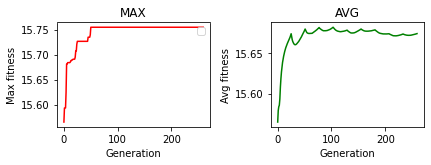

Best solution of best individual: [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [41]:
population_size=20
prob_cross = 0.6
prob_mutation = 0.2
genererations = 10

averege_Fitness_all_gen=list()
maxFitness_all_gen=list()
Howmanygenerations =list()
BestFitnessForAllGens =list()
BestFitnessPerGens =list()
BestFitness = list()
genbest=list()
best={}
final_Bestfitness=list()
X=[]

def main(population_size,prob_cross,prob_mutation):
  
  
  for i in range(10): # iterations
      print("%d ITERATION "%(i+1))

       # dimiourgia plithismou
      pop = toolbox.population(n=population_size)

    #Evaluation fitness function 
      fitnesses = list(map(toolbox.evaluate, pop))
      for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

   
  
    # CXPB pithanotita zeugaromatos
    # MUTPB pithanotita metalakseis
      CXPB, MUTPB = prob_cross, prob_mutation

      #Statistics
      stats = tools.Statistics(key=lambda ind:ind.fitness.values)
      record = stats.compile(pop)
      log = tools.Logbook()
      log.record(gen=0, **record)

	# Extracting all the fitnesses of (epistrefi to fitness)
      fits = [ind.fitness.values[0] for ind in pop]
	
    # Variable keeping track of the number of generations
    #metritis gia generation
      generation=0
      #Save to fitness pou exoume
      previous_fit=max(fits)
      #best fitness apo oles tis genies
      bestfitness=0
  #creteria 
      g = 1
      critiria = False 
      max_g=50
      fitness_unchanged = 0

  # Begin the evolution
      while critiria==False :
        generation +=1

    # A new generation
        print("-- Generation %i --" % generation) 

    # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring)) 

    # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

    # Replace the old population by the offspring
        pop[:] = offspring

    
    # Gather all the fitnesses in one list and print the stats
        fitness = [ind.fitness.values[0] for ind in pop]

        record = stats.compile(pop)
        log.record(gen=g, **record)  
        best = log.select("max")

    #CRETERIA FOR WHILE LOOP(OSO TO TERM=FALSE trexei h while)
        # reached max number of generations
        if g >= max_g:
            critiria = True
            print("<-------------------ITERATION %d COMPLETED ----------------->" %(i+1))
        # best individual of gen is <1% better than best individual of previous gen
        elif (g > 25) and max(fits) < (1.001*previous_fit):
            critiria = True
            print("<-------------------ITERATION %d COMPLETED ----------------->" %(i+1))
        # best individual of gen is same as best individual of previous gen
        elif (g > 25) and previous_fit == max(fits):
            fitness_unchanged += 1
            #ean g>25 kai exw 5 fores stasimo fitness tote critiria=True
            if fitness_unchanged >= 5:
                critiria = True
                print("<-------------------ITERATION %d COMPLETED ----------------->" %(i+1))
            else:
                g += 1
        # else continue
        else:
            fitness_unchanged = 0
            g += 1



      
#------------------------------------EKTELESI GIA KATHE GENIA-----------------------------------------------------------------------------
        #GIA KATHE GENERATION:
        maxFitness_per_gen=(max(fitness))
        average_fitness_per_gen = ((sum(fitness)/len(pop)))
        print(" Max fitness:%s && Average fitness:%s" %((maxFitness_per_gen),(average_fitness_per_gen)))
    

#--------------------------------------TO MEGALITERO KATHE GENIAS KAI TO ANTISTOIXO AVG ----------------------------------------------------------------------
        maxFitness_all_gen.append(maxFitness_per_gen)
        averege_Fitness_all_gen.append(average_fitness_per_gen)

        #TWRA THELOUME APO OLES TIS GENIES NA KRATISOUME MONO ENA, TO MEGALITERO 
        final_Bestfitness.append(max(maxFitness_all_gen))

#----------------------------------------------SUNOLIKES GENIES EKTELESIS---------------------------------------------------------------------------------
        Howmanygenerations.append(g)
#-------------------------------------------------------------------------------------------------------------------------------------------------------
        #PREPEI NA VROUME TO BEST FITNESS 
        best_fitness =max(fitness)
        if best_fitness > bestfitness:
            bestfitness = best_fitness
            Bestindex =pop[fitness.index(best_fitness)]
        BestFitnessPerGens.append(best_fitness)

         
        #Vale stin lista mono to megalutero stoixio pou vrikes
        BestFitnessForAllGens.append(max(BestFitnessPerGens))
        X.append(mean(BestFitnessPerGens))
#################################################################################
      

################################################################################ 

  best_ind =tools.selBest(pop,1)[0]
  print("<------------------------- APOTELESMATA ------------------------>")
  print("Avg for generations:",mean(Howmanygenerations))
  print("Best fitness of best individual:",np.amax(max(BestFitnessForAllGens)))
  print("Avg fitness of best individual:",np.mean(BestFitnessForAllGens))


  plt.figure(0)
  plt.subplot(2, 2, 1)
  plt.plot(BestFitnessForAllGens,color='red')
  plt.title("MAX")
  plt.ylabel("Max fitness")
  plt.xlabel("Generation")
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(X,color="green")
  plt.title("AVG")
  plt.ylabel("Avg fitness")
  plt.xlabel("Generation")
  plt.tight_layout()
  plt.show()

  print("Best solution of best individual:",(best_ind))

  for i in range(len(best_ind)):
    if best_ind[i] == 0:
        tf_idf_Xtrain[i] = 0
 
main(population_size,prob_cross,prob_mutation)  


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf_idf_Xtrain=tf_idf_Xtrain[:8251]
labels_fnames = [
            '/home/spetz/Downloads/DeliciousMIL/Data/train-label.dat',
            ]
y = pd.read_csv(labels_fnames[0] , delimiter = ' ', header = None)

X_train, X_test, Y_train, Y_test = train_test_split(tf_idf_Xtrain, y, test_size=0.3, random_state=42)  


print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(5775,) (2476,) (5775, 20) (2476, 20)
